<a href="https://colab.research.google.com/github/bmil-ssu/advanced_ann/blob/main/2024/Code/Advanced_Ann_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 호출 및 시드 고정 (호출 함수만 추가 가능, 시드 변경 불가)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import random

# 랜덤 시드 고정
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)  # 시드 고정 값 사용

# 하이퍼파리미터 설정 및 모델 정의（하이퍼파리미터 튜닝）(수정 가능 부분)

In [ ]:
# 하이퍼파라미터 설정
batch_size = 256
num_epochs = 10
learning_rate = 1e-2
latent_size = 5

# Autoencoder 모델 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 모델, 손실 함수, 옵티마이저 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#threshold 설정 기준
def find_best_threshold(thresholds, valid_errors, y_valid_combined):
    best_threshold = 0
    best_accuracy = 0
    best_precision = 0
    best_recall = 0
    best_f1 = 0
    best_y_pred = None

    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in thresholds:
        y_pred = (valid_errors > threshold).astype(int)
        acc = accuracy_score(y_valid_combined, y_pred)
        precision = precision_score(y_valid_combined, y_pred, zero_division=0)
        recall = recall_score(y_valid_combined, y_pred, zero_division=0)
        f1 = f1_score(y_valid_combined, y_pred, zero_division=0)

        accuracies.append(acc)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        if acc > best_accuracy:
            best_accuracy = acc
            best_threshold = threshold
            best_precision = precision
            best_recall = recall
            best_f1 = f1
            best_y_pred = y_pred

    return best_threshold, best_accuracy, best_precision, best_recall, best_f1, accuracies, precisions, recalls, f1_scores


# 데이터 로드 및 전처리 (수정 불가)

In [ ]:
# EMNIST 데이터 로드
train_data = pd.read_csv('emnist-balanced-train.csv', header=None)
test_data = pd.read_csv('emnist-balanced-test.csv', header=None)

# 데이터 전처리
X_train = train_data.iloc[:, 1:].values.astype('float32') / 255.
y_train = train_data.iloc[:, 0].values
X_test = test_data.iloc[:, 1:].values.astype('float32') / 255.
y_test = test_data.iloc[:, 0].values

# 28x28 이미지를 1차원 벡터로 변환
X_train = X_train.reshape((X_train.shape[0], 784))
X_test = X_test.reshape((X_test.shape[0], 784))

# Validation 데이터를 Train 데이터에서 3:1 비율로 분리
train_size = int(0.75 * len(X_train))
valid_size = len(X_train) - train_size

train_dataset_full = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_dataset, valid_dataset = random_split(train_dataset_full, [train_size, valid_size])

# Validation 데이터에서 정상(숫자)과 비정상(문자) 데이터 분리
valid_data = torch.stack([data[0] for data in valid_dataset])
valid_labels = torch.tensor([data[1].item() for data in valid_dataset])

valid_digits = valid_data[valid_labels < 10]
valid_digits_labels = torch.zeros(len(valid_digits))  # 정상 데이터
valid_letters = valid_data[valid_labels >= 10]
valid_letters_labels = torch.ones(len(valid_letters))  # 비정상 데이터

# Validation 데이터에서 숫자와 문자의 수를 동일하게 맞추기
min_valid_count = min(len(valid_digits), len(valid_letters))
valid_digits = valid_digits[:min_valid_count]
valid_digits_labels = valid_digits_labels[:min_valid_count]
valid_letters = valid_letters[:min_valid_count]
valid_letters_labels = valid_letters_labels[:min_valid_count]

# 최종 Validation 데이터셋 생성
valid_data_combined = torch.cat([valid_digits, valid_letters])
valid_labels_combined = torch.cat([valid_digits_labels, valid_letters_labels])
valid_dataset_final = TensorDataset(valid_data_combined, valid_labels_combined)

# Train 데이터에서 숫자 데이터만 남기기
X_train_digits = X_train[y_train < 10]
train_dataset = TensorDataset(torch.tensor(X_train_digits), torch.tensor(X_train_digits))

# Test 데이터에서 정상(숫자)과 비정상(문자) 데이터 분리
X_test_digits = X_test[y_test < 10]
X_test_letters = X_test[y_test >= 10]

# Test 데이터에서 숫자와 문자의 수를 동일하게 맞추기
min_test_count = min(len(X_test_digits), len(X_test_letters))
X_test_digits = X_test_digits[:min_test_count]
X_test_letters = X_test_letters[:min_test_count]

test_digits_dataset = TensorDataset(torch.tensor(X_test_digits), torch.zeros(X_test_digits.shape[0]))
test_letters_dataset = TensorDataset(torch.tensor(X_test_letters), torch.ones(X_test_letters.shape[0]))

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset_final, batch_size=batch_size, shuffle=True)
test_digits_loader = DataLoader(test_digits_dataset, batch_size=batch_size)
test_letters_loader = DataLoader(test_letters_dataset, batch_size=batch_size)

# Test 데이터의 정상(숫자)과 비정상(문자) 데이터 결합
X_test_combined = np.concatenate([X_test_digits, X_test_letters], axis=0)
y_test_combined = np.concatenate([np.zeros(len(X_test_digits)), np.ones(len(X_test_letters))], axis=0)

# 모델 학습 (수정 불가)

In [ ]:
# Autoencoder 학습
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data, _ in train_loader:
        data = data.to(device)

        # 순전파
        outputs = model(data)
        loss = loss_fn(outputs, data)

        # 역전파 및 최적화
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/10], Loss: 0.0744
Epoch [2/10], Loss: 0.0476
Epoch [3/10], Loss: 0.0387
Epoch [4/10], Loss: 0.0359
Epoch [5/10], Loss: 0.0343
Epoch [6/10], Loss: 0.0331
Epoch [7/10], Loss: 0.0324
Epoch [8/10], Loss: 0.0317
Epoch [9/10], Loss: 0.0313
Epoch [10/10], Loss: 0.0309


# valid 성능 평가 (수정 불가)

In [ ]:
# Validation 및 Test 데이터셋 평가 함수
def evaluate(loader):
    model.eval()
    reconstruction_errors = []
    labels = []
    with torch.no_grad():
        for data, label in loader:
            data = data.to(device)
            reconstructed = model(data).cpu().numpy()
            reconstruction_error = np.mean(np.abs(reconstructed - data.cpu().numpy()), axis=1)
            reconstruction_errors.extend(reconstruction_error)
            labels.extend(label.numpy())  # 실제 라벨 저장
    return np.array(reconstruction_errors), np.array(labels)

# Validation 및 Test 데이터에 대한 재구성 오차 및 라벨 계산
valid_errors, y_valid_combined = evaluate(valid_loader)
test_digits_errors, _ = evaluate(test_digits_loader)
test_letters_errors, _ = evaluate(test_letters_loader)

# Validation 데이터의 임계값 찾기
thresholds = np.linspace(np.min(valid_errors), np.max(valid_errors), 100)
best_threshold, best_accuracy, best_precision, best_recall, best_f1, accuracies, precisions, recalls, f1_scores = find_best_threshold(thresholds, valid_errors, y_valid_combined)

print(f"Best Threshold (Validation): {best_threshold:.4f}")
print(f"Best Accuracy (Validation): {best_accuracy:.4f}")
print(f"Best Precision (Validation): {best_precision:.4f}")
print(f"Best Recall (Validation): {best_recall:.4f}")
print(f"Best F1-Score (Validation): {best_f1:.4f}")


Best Threshold (Validation): 0.1107
Best Accuracy (Validation): 0.7625
Best Precision (Validation): 0.7674
Best Recall (Validation): 0.7535
Best F1-Score (Validation): 0.7604


# Test 성능 평가 (수정 불가)

Test Accuracy: 0.7524
Precision: 0.7514
Recall: 0.7542
F1-Score: 0.7528


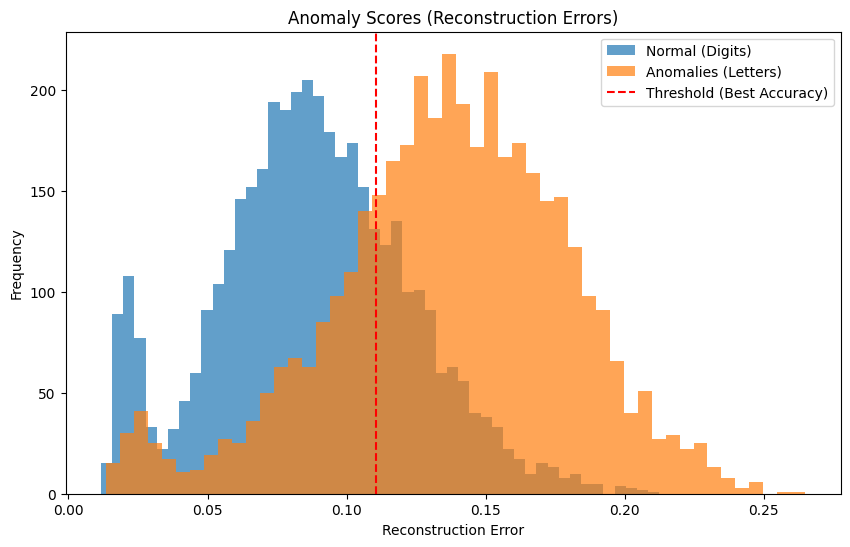

In [ ]:
# 테스트 데이터에 대한 성능 평가
test_combined_dataset = TensorDataset(torch.tensor(X_test_combined), torch.tensor(y_test_combined))
test_combined_loader = DataLoader(test_combined_dataset, batch_size=batch_size)

# 테스트 데이터에 대한 재구성 오차 및 라벨 계산
test_combined_errors, y_test_combined_actual = evaluate(test_combined_loader)

# 임계값을 이용하여 예측 라벨 생성
y_test_pred = (test_combined_errors > best_threshold).astype(int)

# 테스트 데이터에 대한 성능 평가
test_accuracy = accuracy_score(y_test_combined_actual, y_test_pred)
test_precision = precision_score(y_test_combined_actual, y_test_pred, zero_division=0)
test_recall = recall_score(y_test_combined_actual, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test_combined_actual, y_test_pred, zero_division=0)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")

# Anomaly Score (재구성 오차) 그래프 시각화
plt.figure(figsize=(10, 6))
plt.hist(test_digits_errors, bins=50, alpha=0.7, label='Normal (Digits)')
plt.hist(test_letters_errors, bins=50, alpha=0.7, label='Anomalies (Letters)')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Threshold (Best Accuracy)')
plt.title('Anomaly Scores (Reconstruction Errors)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()
